# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [17]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [18]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

print(X_val_feats.shape)
print(X_val.shape)
# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [20]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None
svm = LinearSVM()

#X_train = np.reshape(X_train, (X_train.shape[0], -1))
#X_val = np.reshape(X_val, (X_val.shape[0], -1))
#X_test = np.reshape(X_test, (X_test.shape[0], -1))

#X_train = X_train_feats
#X_val = X_val_feats
#X_test = X_test_feats
#X_val = np.reshape(X_val, (X_val.shape[0], -1))
#X_test = np.reshape(X_test, (X_test.shape[0], -1))

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
print(X_train.shape)
for tmp_learning_rates in learning_rates:
    for tmp_regularization_strengths in regularization_strengths:
        svm.__init__()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=tmp_learning_rates, reg=tmp_regularization_strengths, num_iters=1500,batch_size=200, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        results[(tmp_learning_rates,tmp_regularization_strengths)] = (np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred))
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        if best_val < np.mean(y_val == y_val_pred) :
            best_val = np.mean(y_val == y_val_pred)
            best_svm = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]

    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(49000, 32, 32, 3)
iteration 0 / 1500: loss 85.991914
iteration 100 / 1500: loss 84.478683
iteration 200 / 1500: loss 82.985558
iteration 300 / 1500: loss 81.509196
iteration 400 / 1500: loss 80.071572
iteration 500 / 1500: loss 78.677618
iteration 600 / 1500: loss 77.290545
iteration 700 / 1500: loss 75.936975
iteration 800 / 1500: loss 74.624121
iteration 900 / 1500: loss 73.322465
iteration 1000 / 1500: loss 72.039684
iteration 1100 / 1500: loss 70.788441
iteration 1200 / 1500: loss 69.568398
iteration 1300 / 1500: loss 68.366379
iteration 1400 / 1500: loss 67.184339
validation accuracy: 0.101000
iteration 0 / 1500: loss 739.037446
iteration 100 / 1500: loss 606.620606
iteration 200 / 1500: loss 498.263232
iteration 300 / 1500: loss 409.521389
iteration 400 / 1500: loss 336.886662
iteration 500 / 1500: loss 277.430245
iteration 600 / 1500: loss 228.745864
iteration 700 / 1500: loss 188.898438
iteration 800 / 1500: loss 156.274684
iteration 900 / 1500: loss 129.567869
iteration 1000 

In [21]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.342


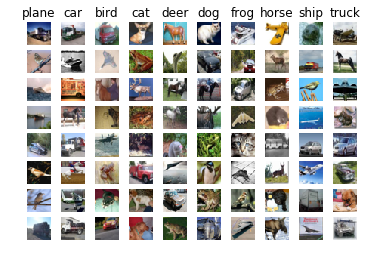

In [22]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [23]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [27]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

hidden_size = np.array(np.linspace(50, 2000,3),dtype=int)
lr_array = np.linspace(0.015,0.001,3)
lrdc_array = [0.95]
rg_array = [0.225] #np.linspace(0.2,10,8) #
val_acc_best = -1
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
for hd in hidden_size:
    for rg in rg_array:
        for lr in lr_array:
            for lrdc in lrdc_array:
            
                net = TwoLayerNet(input_dim, hd, num_classes,std=1e-5) #init_toy_model()
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1000, batch_size=200,
                learning_rate=lr, learning_rate_decay=lrdc,
                reg=rg, verbose=True)

                # Predict on the validation set
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                val_acc_best = np.maximum(val_acc,val_acc_best)
                if val_acc_best == val_acc :
                    best_net = net
                print('Validation accuracy: ', val_acc, lr,rg,hd,lrdc )
                


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302648
iteration 200 / 1000: loss 2.302567
iteration 300 / 1000: loss 2.302535
iteration 400 / 1000: loss 2.302649
iteration 500 / 1000: loss 2.302626
iteration 600 / 1000: loss 2.302563
iteration 700 / 1000: loss 2.302584
iteration 800 / 1000: loss 2.302562
iteration 900 / 1000: loss 2.302657
Validation accuracy:  0.079 0.015 0.225 50 0.95
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302560
iteration 200 / 1000: loss 2.302652
iteration 300 / 1000: loss 2.302619
iteration 400 / 1000: loss 2.302639
iteration 500 / 1000: loss 2.302580
iteration 600 / 1000: loss 2.302598
iteration 700 / 1000: loss 2.302678
iteration 800 / 1000: loss 2.302600
iteration 900 / 1000: loss 2.302554
Validation accuracy:  0.079 0.008 0.225 50 0.95
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302587
iteration 200 / 1000: loss 2.302584
iteration 300 / 1000: loss 2.302588
iteration 400 / 1000: loss 2.302581
iteration 

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)